# Linearising approximately exponential data

A transformation is required to map data that almost follows an exponential curve to a straight line.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from scipy.optimize import minimize

Consider a set of value $x$ that are to be transformed. Let's generate some data to work with.

In [46]:
# Generate data that looks approximately exponential
k = np.arange(0, 5, 0.4)
x = 2 * np.round(1.6**k) + k**3 + np.log(2+k)

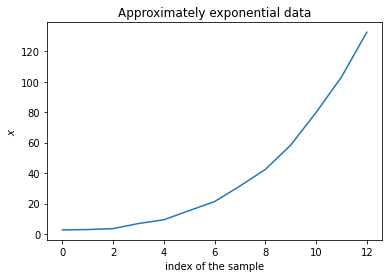

In [47]:
plt.plot(x)
plt.title('Approximately exponential data')
plt.xlabel('index of the sample')
plt.ylabel('$x$')
plt.show()

A measure of how non-linear a set of data is can be found by using linear regression to determine the parameters of the best fit line and then measure the error between the data and that line.

Let $x$ be a list of ordered samples and let $i$ be the index of a sample. The equation of a straight line is given by

$$
\hat{x_i} = m i + c.
$$

The values of $m$ and $c$ can be found using linear regression. The squared error in the straight line fit (with parameters $m$ and $c$) and the data $x$ is given by

$$
\sum_{i=1}^{N-1} (x_i - \hat{x_i})^2 = \epsilon
$$

In [48]:
def linear_error(x):
    """Measure the linear error epsilson."""
    i = np.arange(0, len(x))
    m, c, r_value, p_value, std_err = stats.linregress(i, x)
    
    return np.sum(np.power( x - (m*i + c) , 2))

The problem is that measure of linearity is not scale-invariant. Multiplying the data by a factor of 10 causes the error to increase by about 100.

In [49]:
x1 = np.arange(0,10) + 0.2*np.random.uniform(0, 1, 10)
print(linear_error(x1))
print(linear_error(10*x1))
print(linear_error(10*x1) / linear_error(x1))

0.017344227069374225
1.73442270693744
100.00000000000101


In [113]:
def fit_to_line(x):
    """Fit the data x to a straight line."""
    
    i = np.arange(0, len(x))
    m, c, r_value, p_value, std_err = stats.linregress(i, x)
    
    return m*i + c

In [50]:
def si_linear_error(x):
    """Scale-invariant measure the linear error epsilson."""
    
    x = (x - np.mean(x)) / np.std(x)
    
    i = np.arange(0, len(x))
    m, c, r_value, p_value, std_err = stats.linregress(i, x)
    
    return np.sum(np.power( x - (m*i + c) , 2))

In [112]:
print(si_linear_error(x1))
print(si_linear_error(10*x1))
print(si_linear_error(10*x1) / si_linear_error(x1))

0.002104391927529572
0.0021043919275295885
1.0000000000000078


The scale-invariant linear error measure is essentially the same when the data is scaled (within working precision).

A straight line should have zero error, as is shown below. Notice how the intercepts on the y-axis are evenly spaced.

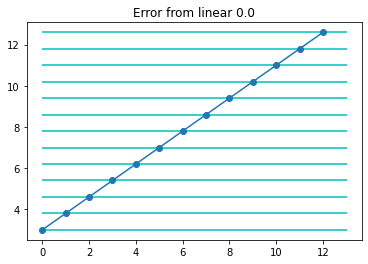

In [52]:
x_linear = 2 * k + 3
plt.plot(x_linear, '-o')
plt.hlines(x_linear, 0, 13, 'c')
plt.title(f'Error from linear {round(si_linear_error(x_linear), 2)}')
plt.show()

The same plot can be produced for the exponential data, but it has a large linear error as expected.

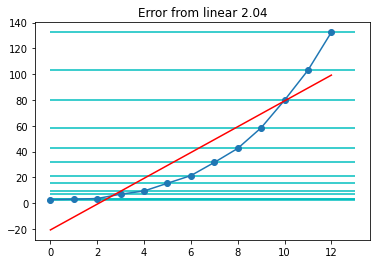

In [114]:
plt.plot(x, '-o')
plt.hlines(x, 0, 13, 'c')
plt.plot(fit_to_line(x), '-r')
plt.title(f'Error from linear {round(si_linear_error(x), 2)}')
plt.show()

If the natural log of the data is taken, i.e. $\log(x)$, the error is as shown below.

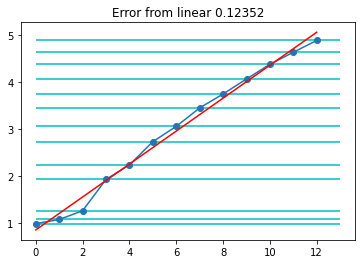

In [115]:
plt.plot(np.log(x), '-o')
plt.hlines(np.log(x), 0, 13, 'c')
plt.plot(fit_to_line(np.log(x)), '-r')
plt.title(f'Error from linear {round(si_linear_error(np.log(x)), 5)}')
plt.show()

To see if the error can be reduced further, the data will be fit to a function of the form

$$
f(x) = \mu \log( \lambda x)
$$

Suppose the data should be mapped to a line, with a minimum value of $\alpha$ and a maximum of $\beta$. The squared error is given by

$$
\sum_{i=0}^{N-1} \Big( \mu \log( \lambda x_i) - \frac{\beta - \alpha}{N-1} i + \alpha    \Big)^2.
$$

To find the values of $(\mu, \lambda)$ a numerical optimisation step will be used.

In [55]:
alpha = 2
beta = 5

In [56]:
def epsilon(p):
    """Error given mu and lambda."""
    mu = p[0]   # mu
    lam = p[1]  # lambda
    N = len(x)
    
    d = ((beta-alpha)/(N-1)) * np.arange(0, len(x)) + alpha
    return np.sum(
                  np.power(mu * np.log(lam*x) - d, 2)
                 )

In [57]:
p0 = [1, 1]  # starting point
res = minimize(epsilon, p0, method='Nelder-Mead', tol=1e-6)
mu_est, lambda_est = res.x
mu_est, lambda_est

(0.7067739532151501, 7.341595959082802)

In [58]:
def f(x):
    return mu_est * np.log(lambda_est * x)

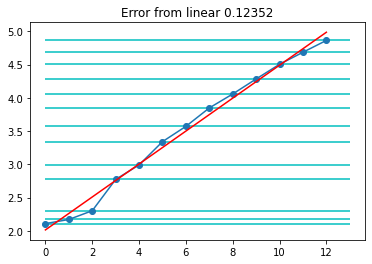

In [116]:
plt.plot(f(x), '-o')
plt.hlines(f(x), 0, 13, 'c')
plt.plot(fit_to_line(f(x)), '-r')
plt.title(f'Error from linear {round(si_linear_error(f(x)), 5)}')
plt.show()

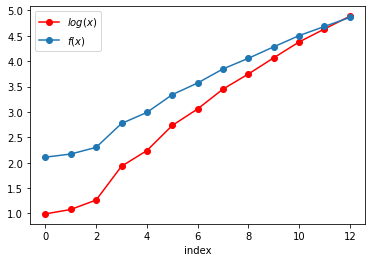

In [60]:
plt.plot(np.log(x), 'or-', label='$log(x)$')
plt.plot(f(x), '-o', label='$f(x)$')
plt.legend()
plt.xlabel('index')
plt.show()

Comparing the original values $x$ to the transformed values $f(x)$:

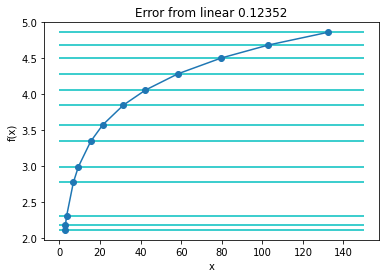

In [62]:
plt.plot(x, f(x), '-o')
plt.hlines(f(x), 0, 150, 'c')
plt.title(f'Error from linear {round(si_linear_error(f(x)), 5)}')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

## Polynomial growth

Polynomial growth is slower than exponential growth, as illustrated in the plot.

In [122]:
k = np.arange(0, 8)
c = 2.5

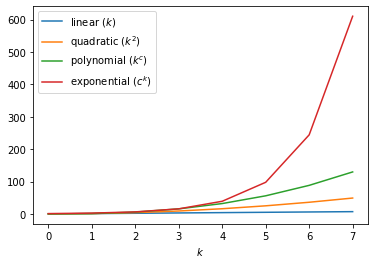

In [123]:
plt.plot(k, label='linear ($k$)')
plt.plot(k**2, label='quadratic ($k^2$)')
plt.plot(k**c, label='polynomial ($k^c$)')
plt.plot(c**k, label='exponential ($c^k$)')
plt.legend()
plt.xlabel('$k$')
plt.show()

Exponential growth can be diagnosed by plotting $\log(x)$. Only the exponential growth curve is a straight line, whereas the rest of the curves are tapering off.

<ipython-input-124-fbc573bcbbe9>:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(k), label='linear ($\log(k)$)')
<ipython-input-124-fbc573bcbbe9>:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(k**2), label='quadratic ($\log(k^2)$)')
<ipython-input-124-fbc573bcbbe9>:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(k**c), label='polynomial ($\log(k^c)$)')


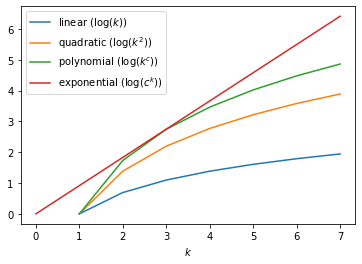

In [124]:
plt.plot(np.log(k), label='linear ($\log(k)$)')
plt.plot(np.log(k**2), label='quadratic ($\log(k^2)$)')
plt.plot(np.log(k**c), label='polynomial ($\log(k^c)$)')
plt.plot(np.log(c**k), label='exponential ($\log(c^k)$)')
plt.legend()
plt.xlabel('$k$')
plt.show()

Suppose the data is generated using

$$
x(k) = a_0 +a_1 (a_2 + k)^{a_3} + n_k
$$

where $a_0$, $a_1$, and $a_2$ are constants, $a_3$ is the constant exponent and $n_k$ is a random noise term.

In [161]:
k = np.arange(0, 8)
a = [2, 1.2, 0.3, 2.1]
x = a[0] + a[1]*np.power((a[2] + x), a[3]) + np.random.normal(0, 1, len(k))

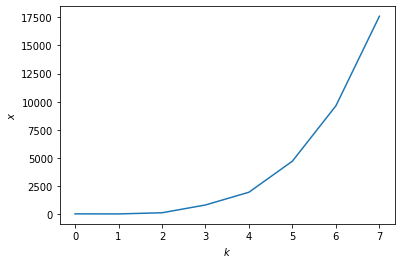

In [162]:
plt.plot(k, x)
plt.xlabel('$k$')
plt.ylabel('$x$')
plt.show()

Ignoring the random noise term, the value of $k$ is given by

$$
k = \Big( \frac{x - a_0}{a_1} \Big)^{\frac{1}{p}} - a_2
$$

The error given the estimates of $[a_0, a_1, a_2]$ is given by

$$
\epsilon = \sum_{i=0}^{N-1} \Big( \Big( \frac{x - a_0}{a_1} \Big)^{\frac{1}{p}} - a_2 - i \Big)^2.
$$

In [163]:
def epsilon(a):
    p = a[3]
    i = np.arange(0, len(x))
    return  np.sum(
                    np.power(
                        np.power(((x - a[0])/a[1]), 1/p) - a[2] - i, 
                        2)
                   )

In [164]:
p0 = [0, 1, 0, 1]  # starting point
res = minimize(epsilon, p0, method='Nelder-Mead', tol=1e-6)
a_fit = res.x
a_fit

array([0.81078864, 0.0525361 , 2.28081652, 5.72379877])

In [165]:
def fitted(a, k):
    return a[0] + a[1]*np.power((a[2] + k), a[3])

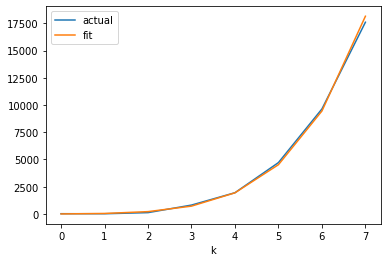

In [166]:
plt.plot(x, label='actual')
plt.plot(fitted(a_fit, k), label='fit')
plt.xlabel('k')
plt.legend()
plt.show()